In [ ]:
%%html
<style type="text/css">
  span.ecb { background: yellow; }
</style>

# ATMO 5331 - Homework 3 - Fall 2021
## Due 5 Oct, 2021

When doing this homework, remember that you have two jobs:
1. Make it work.
2. Clean it up so that I can understand what you've done. If you think I might not understand, document it with a comment or a function docstring.

You should present your work with a clear logical progression. If that seems like a hassle, remember that in doing so you are practicing skills that are expected in your thesis and journal publications.

You may work alone or in pairs. I will not be adjudicating relative level of effort in group work, so you are responsible for ensuring that you and your partner contribute equally.

<span class="ecb">Comments by ECB</span>

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

For this assignment, download some [sample Ka data](http://www.atmo.ttu.edu/bruning/5331/Ka2140614021408.RAWPXA9.nc). These data were converted directly from the raw format collected by the radar (Sigmet) to the [NetCDF CF/Radial standard](http://ncar.github.io/CfRadial/). No further processing has been applied.

In the file, the radar variables (such as reflectivity) are stored in arrays with dimension `(time, range)`. At each time, a single ray of data is collected, which extends along range. There is also a `sweep` dimension that corresponds to a few different variables. These variables mark the start and the end of each radar scan. Let's look at that structure:

In [2]:
# d = xr.open_dataset('../../../cfrad.20080604_002217_000_SPOL_v36_SUR.nc')
d = xr.open_dataset('C:/Users/jdufo/Downloads/Ka2140614021408.RAWPXA9.nc')

print(d)

# Print the first ten elevation angles.
print(d.variables['elevation'][0:10])

# Shortcut to variable access
print(d.elevation[0:10])

<xarray.Dataset>
Dimensions:                    (range: 1666, sweep: 5, time: 2938)
Coordinates:
  * time                       (time) datetime64[ns] 2014-06-14T02:14:19 ... ...
  * range                      (range) float32 0.0 15.0 30.0 ... 24960.0 24975.0
    azimuth                    (time) float32 ...
    elevation                  (time) float32 ...
Dimensions without coordinates: sweep
Data variables:
    total_power                (time, range) float32 ...
    reflectivity               (time, range) float32 ...
    velocity                   (time, range) float32 ...
    spectrum_width             (time, range) float32 ...
    normalized_coherent_power  (time, range) float32 ...
    sweep_number               (sweep) int32 ...
    fixed_angle                (sweep) float32 ...
    sweep_start_ray_index      (sweep) int32 ...
    sweep_end_ray_index        (sweep) int32 ...
    sweep_mode                 (sweep) |S32 ...
    unambiguous_range          (time) float32 ...
    pr

<xarray.DataArray 'sweep_mode' (sweep: 5)>
array([b'rhi', b'rhi', b'rhi', b'rhi', b'rhi'], dtype='|S32')
Dimensions without coordinates: sweep
Attributes:
    long_name:      Sweep mode
    units:          unitless
    standard_name:  sweep_mode
    comment:        Options are: "sector", "coplane", "rhi", "vertical_pointi...
<xarray.DataArray 'sweep_start_ray_index' (sweep: 5)>
array([   0,  590, 1176, 1766, 2352])
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of first ray in sweep, 0-based
    units:      count
<xarray.DataArray 'sweep_end_ray_index' (sweep: 5)>
array([ 589, 1175, 1765, 2351, 2937])
Dimensions without coordinates: sweep
Attributes:
    long_name:  Index of last ray in sweep, 0-based
    units:      count


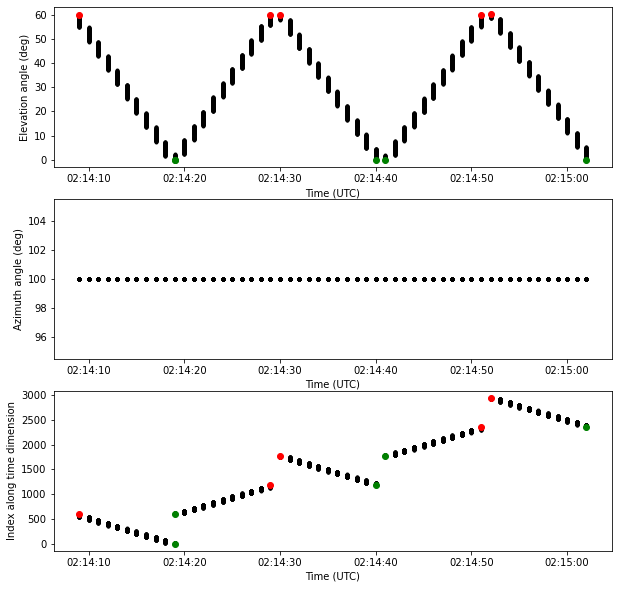

In [3]:
print(d.sweep_mode)
print(d.sweep_start_ray_index)
print(d.sweep_end_ray_index)

az = d.azimuth[:]
el = d.elevation[:]
t = d.time[:]
fig, axs = plt.subplots(3,1, squeeze=False, figsize=(10,10))

axs[0,0].plot(t,el, '.k')
axs[0,0].set_ylabel('Elevation angle (deg)')
axs[0,0].set_xlabel('Time (UTC)')
axs[1,0].plot(t,az, '.k')
axs[1,0].set_ylabel('Azimuth angle (deg)')
axs[1,0].set_xlabel('Time (UTC)')
axs[2,0].plot(t, np.arange(t.shape[0]), '.k')
axs[2,0].set_ylabel('Index along time dimension')
axs[2,0].set_xlabel('Time (UTC)')
for sw_start, sw_end in zip(d.sweep_start_ray_index, d.sweep_end_ray_index):
    axs[0,0].plot(t[sw_start], el[sw_start], marker='o', color='g')
    axs[0,0].plot(t[sw_end], el[sw_end], marker='o',color='r')
    axs[2,0].plot(t[sw_start], sw_start, marker='o', color='g')
    axs[2,0].plot(t[sw_end], sw_end, marker='o',color='r')

The green dots mark the start of a sweep according to `sweep_start_ray_index`, and red marks the end according to `sweep_end_ray_index`. We observe that:

0. the scans are in [RHI](http://ww2010.atmos.uiuc.edu/(Gh)/guides/rs/rad/basics/cnmod.rxml) mode, per the scan_mode variable.
1. the data have time precision of 1 s
2. the data are not stored in time order.
3. the data are stored in the file in order of increasing elevation angle, not increasing time.
4. azimuth angle is constant.

For the rest of this assignment, let's work with the second of the five scans, where time and elevation both increase with index along the time dimension. Reuse this variable instead of hard-coding a scan number in later code.

In [4]:
scan_idx = 1

**1.** Let's start by preparing the coordinates needed to plot a scan. Write a function that takes a radar dataset and scan index, and returns  D arrays of ranges, azimuths, and elevations that correspond to the edges of each radar sample (a.k.a., each gate). Your function should return three separate 2d variables, as you see in the sample function call below. I found it helpful to visualize how the coordinates were distributed in 2D a quick, unlableled plot of each coordinate: `plt.imshow(r)`.

In [5]:
idx_start = d.sweep_start_ray_index[scan_idx]
idx_end = d.sweep_end_ray_index[scan_idx]

def spherical_coords(data, scan):  
    r_1d = np.array(data.range)
    az_1d = np.array(data.azimuth[idx_start.values:idx_end.values+1])
    el_1d = np.array(data.elevation[idx_start.values:idx_end.values+1])
    
    return r_1d, az_1d, el_1d

r, az, el = spherical_coords(d, scan_idx)
# print(r.shape)
# print(az.shape)
# print(el.shape)

def coords_2d(r, az, el):
    #ranges, azimuth, elevation = spherical_coords(data, scan)
    
    r_2d, az_2d = np.meshgrid(r, az)
    r_2d, el_2d = np.meshgrid(r, el)
    #el_2d = np.full_like(az_2d, el[0])
    
    return r_2d, az_2d, el_2d

range_2d, azimuth_2d, elevation_2d = coords_2d(r, az, el)

# print(range_2d.shape)
# print(azimuth_2d.shape)
# print(elevation_2d.shape)

**2.** Make a 4-panel plot of reflectivity, velocity, spectrum width, and normalized coherent power. Use `coordinateSystems.RadarCoordinateSystem` to plot in altitude above vs. range along a tangent plane. The tangent plane should be centered at the location of radar.

Note that if you find that the coordinate transformations fail to preserve the shape of your input coordinate arrays, you can fix it with `X.shape = r.shape`, where `X` has been transformed from `r`.

In [6]:
from metpy.plots import ctables
NWSReflectivity = ctables.registry.get_colortable('NWSReflectivity')
NWSVelocity = ctables.registry.get_colortable('NWSVelocity')
NWSSpecWidth = ctables.registry.get_colortable('NWSSpectrumWidth')
NWSNorm = ctables.registry.get_colortable('Carbone42')

from coordinateSystems import TangentPlaneCartesianSystem
from coordinateSystems import RadarCoordinateSystem

radar = RadarCoordinateSystem(d.latitude, d.longitude, d.altitude)
X, Y, Z = radar.toECEF(range_2d, azimuth_2d, elevation_2d)

tan = TangentPlaneCartesianSystem(d.latitude, d.longitude, d.altitude)
X1, Y1, Z1 = tan.fromECEF(X, Y, Z)

idx_start_plot = d.sweep_start_ray_index[scan_idx]
idx_end_plot = d.sweep_end_ray_index[scan_idx]

reflect = np.array(d.reflectivity[idx_start_plot.values:idx_end_plot.values+1])
velocity = np.array(d.velocity[idx_start_plot.values:idx_end_plot.values+1])
spec_wid = np.array(d.spectrum_width[idx_start_plot.values:idx_end_plot.values+1])
norm_co_power = np.array(d.normalized_coherent_power[idx_start_plot.values:idx_end_plot.values+1])


X1.shape = range_2d.shape
Y1.shape = azimuth_2d.shape
Z1.shape = elevation_2d.shape

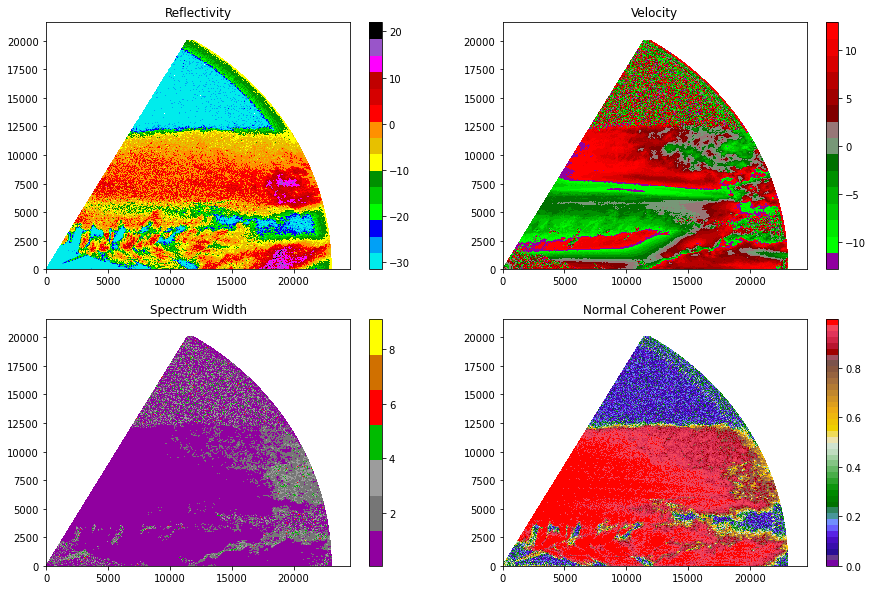

In [7]:
fig, axs = plt.subplots(2,2, squeeze=False, figsize=(15,10))

im1 = axs[0,0].pcolormesh(X1, Z1, reflect, cmap = NWSReflectivity)
axs[0,0].set_title('Reflectivity')
#axs[0,0].set_xlabel('Time (UTC)')
plt.colorbar(im1, ax=axs[0,0])
                   
im2 = axs[0,1].pcolormesh(X1, Z1, velocity, cmap = NWSVelocity)
axs[0,1].set_title('Velocity')
#axs[0,1].set_xlabel('Time (UTC)')
plt.colorbar(im2, ax=axs[0,1])

im3 = axs[1,0].pcolormesh(X1, Z1, spec_wid, cmap = NWSSpecWidth)
axs[1,0].set_title('Spectrum Width')
#axs[1,0].set_xlabel('Time (UTC)')
plt.colorbar(im3, ax=axs[1,0])  

im4 = axs[1,1].pcolormesh(X1, Z1, norm_co_power, cmap = NWSNorm)
axs[1,1].set_title('Normal Coherent Power')
#axs[1,1].set_xlabel('Time (UTC)')
plt.colorbar(im4, ax=axs[1,1])

**3.** Repeat the plot for question 2, but for an azimuthal equidistant map projection centered at the radar location.

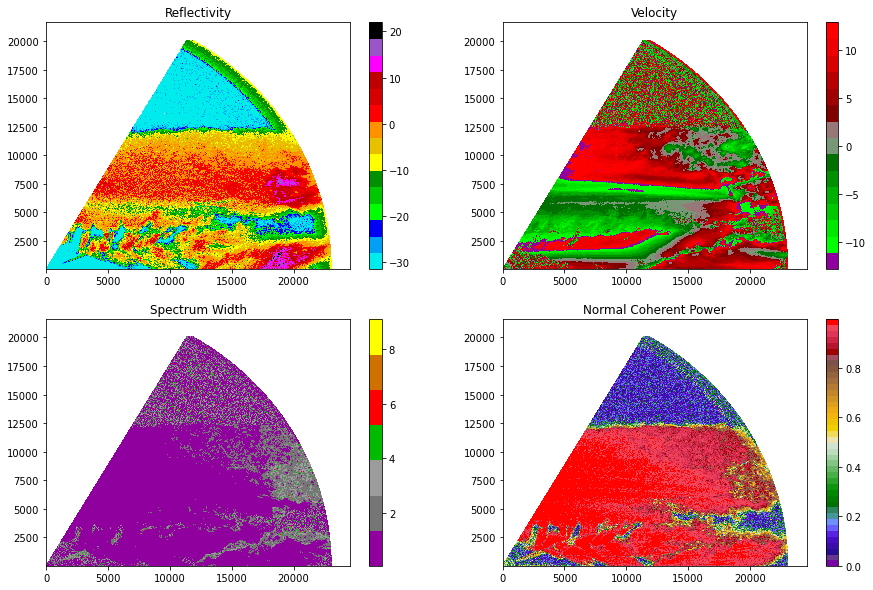

In [12]:
# Where is the radar? What is its gate spacing?

# print(d.latitude)
# print(d.longitude)
# print(d.range[1]-d.range[0])

lon = d.longitude.values
lat = d.latitude.values

from coordinateSystems import MapProjection

az_equi = MapProjection(projection = 'aeqd', lon_0 = lon, lat_0 = lat)
X_az, Y_az, Z_az = az_equi.fromECEF(X, Y, Z)

X_az.shape = range_2d.shape
Y_az.shape = azimuth_2d.shape
Z_az.shape = elevation_2d.shape

fig, axs = plt.subplots(2,2, squeeze=False, figsize=(15,10))

im1 = axs[0,0].pcolormesh(X_az, Z_az, reflect, cmap = NWSReflectivity)
axs[0,0].set_title('Reflectivity')
#axs[0,0].set_xlabel('Time (UTC)')
plt.colorbar(im1, ax=axs[0,0])
                   
im2 = axs[0,1].pcolormesh(X_az, Z_az, velocity, cmap = NWSVelocity)
axs[0,1].set_title('Velocity')
#axs[0,1].set_xlabel('Time (UTC)')
plt.colorbar(im2, ax=axs[0,1])

im3 = axs[1,0].pcolormesh(X_az, Z_az, spec_wid, cmap = NWSSpecWidth)
axs[1,0].set_title('Spectrum Width')
#axs[1,0].set_xlabel('Time (UTC)')
plt.colorbar(im3, ax=axs[1,0])  

im4 = axs[1,1].pcolormesh(X_az, Z_az, norm_co_power, cmap = NWSNorm)
axs[1,1].set_title('Normal Coherent Power')
#axs[1,1].set_xlabel('Time (UTC)')
plt.colorbar(im4, ax=axs[1,1])

To set the stage for the next two assignments, let's say we want to oversample the 15 m range gates to a 5 m carteisian grid in the domain 9.0…9.5 km range and 2.9…3.4 km altitude. Once again, we will use the distance above and the range along the tangent plane.

**4.** Create 2D arrays giving the corresponding center locations for each desired analysis location. Start with 1D grid box edges spanning the range above.

**5.** For the next question, we will interpolate in three ways:
- nearest neighbor
- linear
- the traditional meteorological "Barnes" analysis (which is really a Gaussian blur fliter). 

To do so, we will use MetPy's built-in interpolators. It wraps SciPy's built-in nearest and linear interpolation methods, and adds Barnes, natural neighbor, and other interpolators. 

You will probably need to install metpy with `conda install -c conda-forge metpy`.

Once you have installed MetPy, use its `interpolate_to_points` function. Note that it takes three arguments, and those arguments require that you use `np.vstack` to rearrange the locations and data into the correct shape.

So that the Barnes analysis doesn't take forever, you will want to subset the data to only those locations that overlap with the analysis grid.

In [ ]:
# from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator, griddata
# from metpy.units import units
from metpy.interpolate import interpolate_to_points
interpolate_to_points?

**6.** Make a plot of the original data and the three interpolation methods. Compared to the original data, what do the three interpolation methods do to the data? Think about what you would regard as desirable properties of an analysis.